In [590]:
import gc
import sys
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [591]:
plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [592]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_10000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_10000.npy')

# Load extracted raw signals
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

In [593]:
spectrogram_imgs.shape

(10000, 200, 300, 3)

In [594]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [595]:
classifier_labels

array([1, 1, 1, ..., 0, 0, 0])

In [596]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
waveform_imgs_earthquakes_only = waveform_imgs[earthquakes_indices]
spectrogram_imgs_earthquakes_only = spectrogram_imgs[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

In [597]:
regressor_target_cols = ['source_magnitude','p_arrival_sample','s_arrival_sample']
regressor_target_names = ['Source Magnitude','P-wave Arrival','S-save Arrival']
regressor_labels = np.array(metadata_earthquakes_only[regressor_target_cols])
regressor_labels.shape

# regressor_target_cols = ['source_magnitude']
# regressor_target_names = ['Source Magnitude']
# regressor_labels = np.array(metadata_earthquakes_only[regressor_target_cols])
# regressor_labels.shape

(5081, 3)

In [598]:
# subsample_indices = np.random.choice(len(spectrogram_imgs), size=2000)
# subsample_imgs = spectrogram_imgs[subsample_indices]
# subsample_metadata = metadata.iloc[subsample_indices]

In [599]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample,label
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07,1
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07,1
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07,1
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07,1
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMKA.AV_20180115125824_NO,AV,AMKA,BH,51.377100,179.300000,116.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-15 12:58:24,noise,6,4.247619e-06,0
9996,ANM.AK_201012072324_NO,AK,ANM,BH,64.564600,-165.373200,338.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2010-12-07 23:24:00,noise,6,4.247619e-06,0
9997,MPK.NN_201508190953_NO,NN,MPK,HH,39.295670,-120.030170,2484.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2015-08-19 09:53:00,noise,6,4.247619e-06,0
9998,NAPC.NC_201605150336_NO,NC,NAPC,HN,38.439510,-122.252720,716.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2016-05-15 03:36:00,noise,6,4.247619e-06,0


In [600]:
def image_preprocessing(image, image_size=(300,200)):
    image = tf.image.resize(image, image_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [601]:
def prepare_datasets(imgs, labels, preproc_func, batch_size=32):
    X_train, X_test, y_train, y_test = train_test_split(imgs, labels, random_state=0, test_size=0.25)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.25)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    train_dataset = train_dataset.map(lambda x, y: (preproc_func(x), y))
    val_dataset = val_dataset.map(lambda x, y: (preproc_func(x), y))
    test_dataset = test_dataset.map(lambda x, y: (preproc_func(x), y))
    
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [602]:
train_dataset_c, val_dataset_c, test_dataset_c = prepare_datasets(imgs=spectrogram_imgs, labels=classifier_labels, preproc_func=image_preprocessing, batch_size=32)

In [603]:
train_dataset_r, val_dataset_r, test_dataset_r = prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=regressor_labels, preproc_func=image_preprocessing, batch_size=32)

In [604]:
# Callback to stop model training early if loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    mode='min',
    patience=5,                # number of epochs to wait for improvement
    restore_best_weights=True, # restore the best weights once training stops
    verbose=1                 
)

# Callback to reduce learning rate if loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,                # the factor by which the learning rate will be reduced
    patience=2,                # number of epochs to wait for improvement
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True        # save only the best model
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [605]:
# classifier model
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 10 output classes
])

In [579]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
classifier_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=10, callbacks=callbacks, validation_data=val_dataset_c)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 598ms/step - accuracy: 0.7160 - loss: 0.5866 - val_accuracy: 0.9104 - val_loss: 0.3530 - learning_rate: 1.0000e-06
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 610ms/step - accuracy: 0.9168 - loss: 0.3301 - val_accuracy: 0.9365 - val_loss: 0.2503 - learning_rate: 1.0000e-06
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 611ms/step - accuracy: 0.9417 - loss: 0.2463 - val_accuracy: 0.9429 - val_loss: 0.2053 - learning_rate: 1.0000e-06
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 610ms/step - accuracy: 0.9460 - loss: 0.2069 - val_accuracy: 0.9525 - val_loss: 0.1789 - learning_rate: 1.0000e-06
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 612ms/step - accuracy: 0.9468 - loss: 0.1844 - val_accuracy: 0.9499 - val_loss: 0.1605 - learning_rate: 1.0000e-06
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 609ms/step - accuracy: 0.9526 - loss: 0.1680 - val_accuracy: 0.9611 - val_loss: 0.1470 - learning_rate: 1.0000e-06
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 

In [580]:
def plot_training_history(history):
    if 'accuracy' and 'val_accuracy' in history.history.keys():
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax1.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax1.grid(True, alpha=0.2, zorder=5)
        ax1.set_title('Model loss')
        ax1.set_ylabel('Loss (sparse categorical crossentropy)')
        ax1.set_xlabel('Epoch')
        ax1.legend()   
        ax2.plot(history.history['accuracy'], color='xkcd:cranberry', label='Training accuracy')
        ax2.plot(history.history['val_accuracy'], color='xkcd:dusty blue', label='Validation accuracy')
        ax2.grid(True, alpha=0.2, zorder=5)
        ax2.set_title('Model Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()    
        plt.tight_layout()
        plt.show()
    elif 'loss' and 'val_loss' in history.history.keys():
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax.grid(True, alpha=0.2, zorder=5)
        ax.set_title('Model loss')
        ax.set_ylabel('Loss (sparse categorical crossentropy)')
        ax.set_xlabel('Epoch')
        ax.legend()
        plt.tight_layout()
        plt.show()        

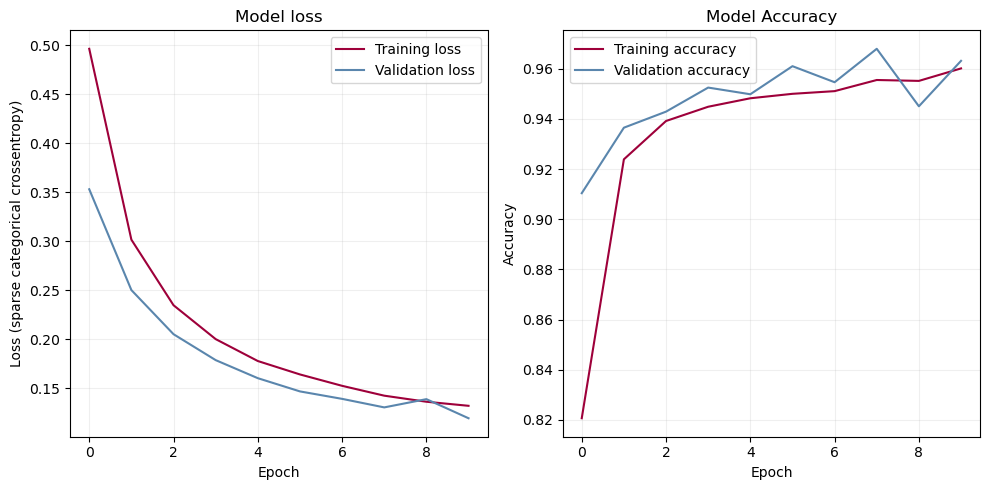

In [581]:
plot_training_history(classifier_history)

In [582]:
def evaluate_classification_model(trained_model, test_dataset):
    # Parse test labels from test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')    
    print('Finding predicted classes and probabilities')
    predicted_classes = np.argmax(trained_model.predict(test_dataset),axis=-1) # predict the class of each image
    predicted_probs = trained_model.predict(test_dataset) # predict the probability of each image belonging to a class
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    precision = precision_score(test_labels, predicted_classes)
    recall = recall_score(test_labels, predicted_classes)
    f1 = f1_score(test_labels ,predicted_classes)
    print(f'Model accuracy: {accuracy}\n Model precision: {precision}\n Model recall: {recall}\n Model F1 score: {f1}')

    # Create confusion matrix
    print('Building confusion matrix')
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)  

    # Plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))  
    disp.plot(cmap='Blues', ax=ax1, values_format='')
    ax1.set_title('Classification CNN Results')
    ax2.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='lightgray', linestyle='--')  # diagonal line (random classifier)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()
    

Evaluating model on test dataset
Finding predicted classes and probabilities
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step
Model accuracy: 0.9612
 Model precision: 0.9804719283970708
 Model recall: 0.9428794992175273
 Model F1 score: 0.9613083366573594
Building confusion matrix


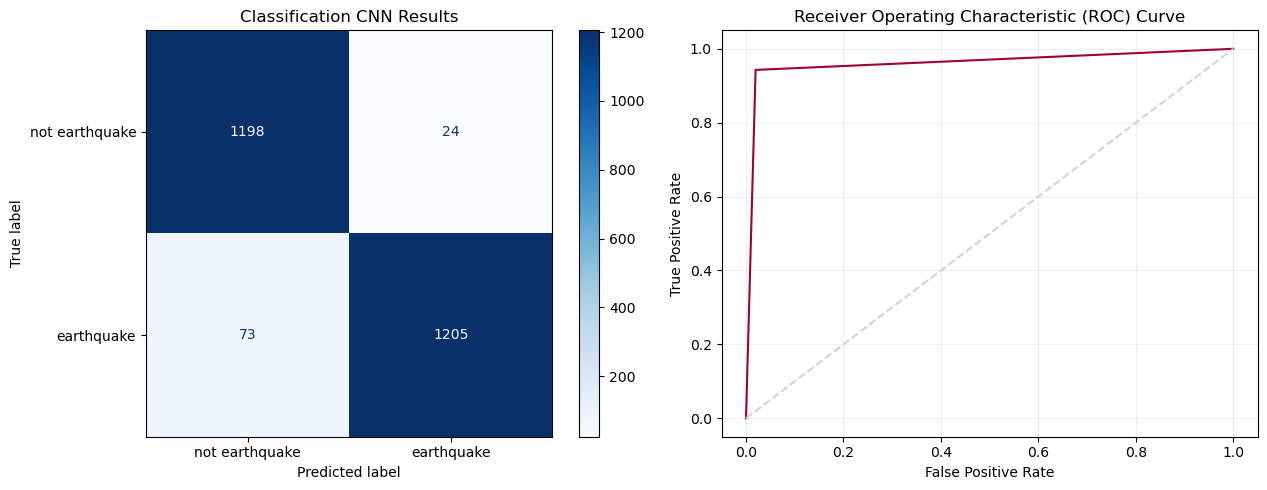

In [583]:
evaluate_classification_model(classifier_model, test_dataset_c)

In [ ]:
input_shape = (waveform_imgs_earthquakes_only.shape[1], waveform_imgs_earthquakes_only.shape[2])
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Separate heads for each target variable
head_1 = layers.Dense(1, name='output_1')(x)  # Head for the first target variable
head_2 = layers.Dense(1, name='output_2')(x)  # Head for the second target variable
head_3 = layers.Dense(1, name='output_3')(x)  # Head for the third target variable

# Create model with multiple outputs
model = models.Model(inputs=inputs, outputs=[head_1, head_2, head_3])
model.compile(
    optimizer='adam',
    loss={'output_1': 'mse', 'output_2': 'mse', 'output_3': 'mse'},
    metrics={'output_1': 'mae', 'output_2': 'mae', 'output_3': 'mae'}
)
    

regressor_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(len(regressor_target_names))
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
regressor_model.compile(optimizer=opt,loss='mse')
regressor_history = regressor_model.fit(train_dataset_r, epochs=50, callbacks=callbacks, validation_data=val_dataset_r)

In [606]:
regressor_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(len(regressor_target_names))
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
regressor_model.compile(optimizer=opt,loss='mse')
regressor_history = regressor_model.fit(train_dataset_r, epochs=50, callbacks=callbacks, validation_data=val_dataset_r)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - loss: 849926.1875 - val_loss: 687949.8125 - learning_rate: 1.0000e-05
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 645568.6250 - val_loss: 426025.0625 - learning_rate: 1.0000e-05
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 382330.3438 - val_loss: 243043.8750 - learning_rate: 1.0000e-05
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 231828.1250 - val_loss: 185296.8750 - learning_rate: 1.0000e-05
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 178409.0625 - val_loss: 166916.0312 - learning_rate: 1.0000e-05
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 165412.4531 - val_loss: 156125.2500 - learning_rate: 1.0000e-05
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 157490.4375 - val_loss: 149441.1562 - learning_rate: 1.0000e-05
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 149821.3281 - val_loss: 144903.0781 - learning_rate: 1.0000e-05
Epoch 9/50
90/90 ━━━━━━━

In [614]:
def evaluate_regression_model(trained_model, test_dataset, target_variables):
        # Parse test labels from test dataset
        test_labels = []
        for _, labels in test_dataset:
            test_labels.append(labels.numpy())
        test_labels = np.concatenate(test_labels)
        print(test_labels.shape)
    
        print('Evaluating model on test dataset')
        test_loss = trained_model.evaluate(test_dataset, verbose=1)
        print(f'Test data loss: {test_loss}')
        
        print('Getting predictions')
        predicted = trained_model.predict(test_dataset)
        print(predicted.shape)

        num_target_variables = len(target_variables)
        fig, axs = plt.subplots(num_target_variables, 1, figsize=(6,6*num_target_variables))
        for i, ax in enumerate(axs.flatten()):
            plot_max = max(test_labels[:,i].max(), predicted[:,i].max())
            plot_min = min(-0.5, test_labels[:,i].min(), predicted[:,i].min())
            ax.scatter(test_labels[:,i], predicted[:,i], color='xkcd:dusty blue', alpha=0.25)
            ax.plot([plot_min*0.9,plot_max*1.1],[plot_min*0.9,plot_max*1.1],color='black', linestyle='--')
            ax.set_ylabel('Predicted Value',fontsize=14)
            ax.set_xlabel('Observed Value',fontsize=14)
            ax.set_title(f'{target_variables[i]}')
            ax.set_xlim([plot_min*0.9, plot_max*1.1])
            ax.set_ylim([plot_min*0.9, plot_max*1.1])
            ax.grid(True, alpha=0.2, zorder=5)
        plt.tight_layout()
        plt.show()

(1271, 3)
Evaluating model on test dataset
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 55323.3125
Test data loss: 56740.8203125
Getting predictions
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step
(1271, 3)


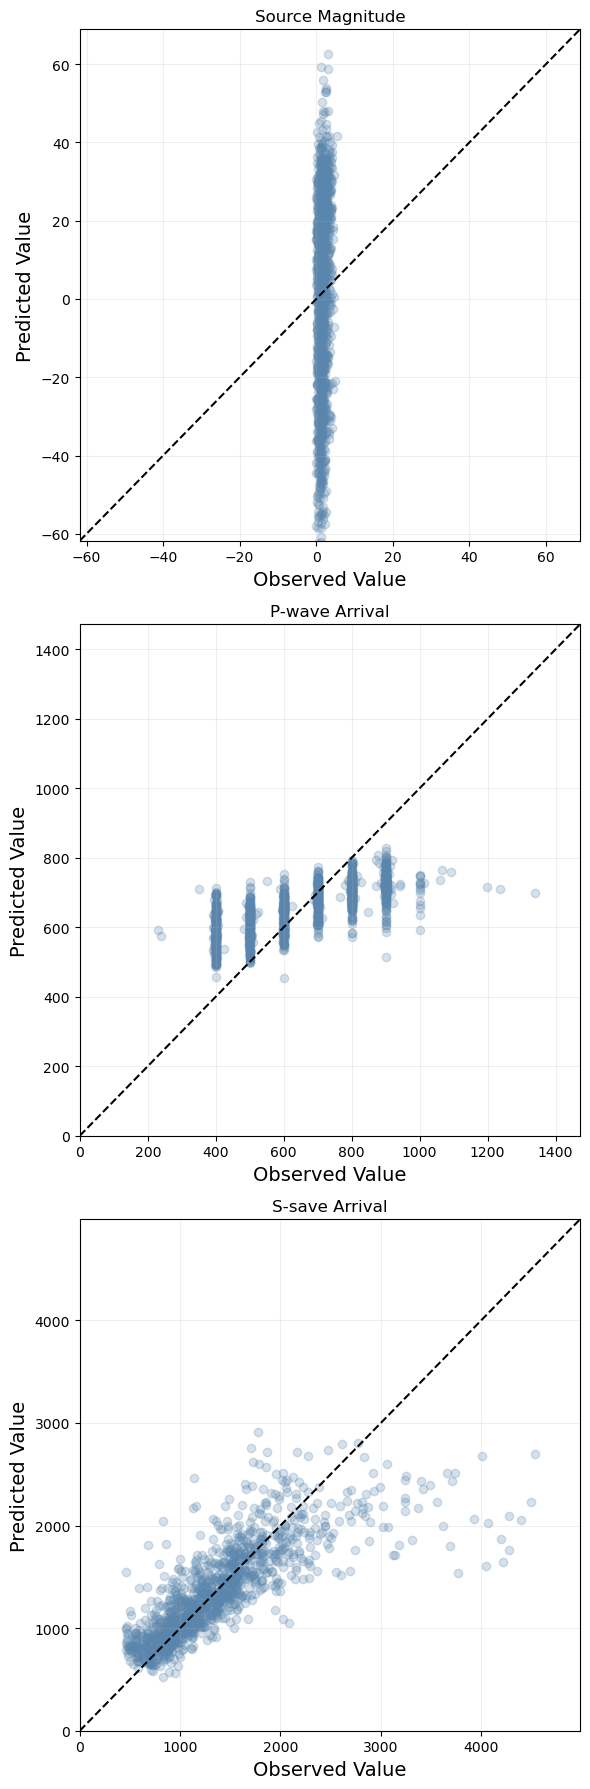

In [615]:
evaluate_regression_model(regressor_model, test_dataset_r, target_variables=regressor_target_names)

In [ ]:
plot_training_history(regressor_history)